# Read in the features df 

In [38]:
import os 
import pandas as pd

features_file_path = 'features.csv'

my_bucket = os.getenv('WORKSPACE_BUCKET')

# copy csv file from the bucket to the current working space
os.system(f"gsutil cp '{my_bucket}/data/{features_file_path}' .")

print(f'[INFO] {features_file_path} is successfully downloaded into your working space')
# save dataframe in a csv file in the same workspace as the notebook
features1_df = pd.read_csv(features_file_path)


CommandException: No URLs matched: gs://fc-secure-8c660c1c-a66c-4f59-a08f-791c07e84203/data/features.csv


[INFO] features.csv is successfully downloaded into your working space


# Split df into features and outcome

In [2]:
features_df = features1_df.drop(columns=['outcome', 'person_id'])
outcome_df = features1_df.outcome

In [3]:
outcome_df.value_counts()

outcome
0    103321
1     24166
Name: count, dtype: int64

Roughly 19% of our cohort has chronic kidney disease. This is a class imbalance and would impact the model by likely predicting most patients as not having CKD. To avoid this, we are going to try a few methods from the imbalanced learn python package. 

# Split train and test data

Splitting to an 80/20 train and test dataset

In [4]:
from sklearn.model_selection import train_test_split
features_train, features_test, outcome_train, outcome_test = train_test_split(features_df, outcome_df, test_size=0.2, random_state=2)

In [5]:
features_train.shape, features_test.shape, outcome_train.shape, outcome_test.shape

((101989, 35), (25498, 35), (101989,), (25498,))

In [6]:
features_train.isna().sum()

ethnicity                                         0
sex                                               0
Age                                               0
BMI                                               0
dbp                                               0
sbp                                               0
Albumin                                           0
Creatinine                                        0
Glucose                                           0
Potassium                                         0
Sodium                                            0
Urea                                              0
smoking_status                                    0
alcohol_score                                     0
mental_health                                     0
physical_health                                   0
afford_provider                                   0
diabetes                                          0
hypertension                                      0
Erythrocytes

# Apply oversampling techniques on our training CKD patients

I am going to use SMOTE, or synthetic minority oversampling technique. 

In [7]:
import imblearn
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=1)
features_resampled_train, outcome_resampled_train = smote.fit_resample(features_train, outcome_train)

In [8]:
from collections import Counter
counter = Counter(outcome_resampled_train)
print(counter)


Counter({0: 82715, 1: 82715})


Now we have an exactly 50/50 ratio of CKD patients to nonCKD patients. 

Some models can handle an imbalance relativley well, but in the case they don't, I will train using the oversampled data. 

# Build the decision tree

In [9]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion='entropy',max_depth=13)
tree.fit(features_resampled_train, outcome_resampled_train)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

Print metrics

In [10]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

def print_classification_metrics(y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred))
    print("Recall:", recall_score(y_true, y_pred))
    print("F1 Score:", f1_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

In [11]:
y_pred = tree.predict(features_test)
print_classification_metrics(outcome_test ,y_pred)

Accuracy: 0.8462232331947603
Precision: 0.592599656685104
Recall: 0.6351185609157809
F1 Score: 0.6131228416378885
Confusion Matrix:
 [[18470  2136]
 [ 1785  3107]]


Rank feature importance 

In [12]:
feature_importance_df = pd.DataFrame({"feature": list(features_resampled_train.columns),
                                      "importance": tree.feature_importances_}
                                     ).sort_values("importance", ascending=False)
feature_importance_df

,feature,importance
18,hypertension,0.307998
7,Creatinine,0.251185
22,anemia,0.141713
2,Age,0.054899
27,cad,0.040171
17,diabetes,0.039841
1,sex,0.019654
26,proteinuria,0.018191
6,Albumin,0.013813
19,Erythrocytes,0.012450


# Build random forest 

In [13]:
from sklearn.ensemble import RandomForestClassifier

In [14]:
randforest = RandomForestClassifier(n_estimators=100, max_depth = 30)
randforest.fit(features_train, outcome_train)

RandomForestClassifier(max_depth=30)

In [15]:
y_pred_rf = randforest.predict(features_test)
print_classification_metrics(outcome_test,y_pred_rf)

Accuracy: 0.8755196485998902
Precision: 0.780718954248366
Recall: 0.4883483237939493
F1 Score: 0.6008551307847082
Confusion Matrix:
 [[19935   671]
 [ 2503  2389]]


## Random forest oversampled

In [16]:
rForest = RandomForestClassifier(n_estimators=100)
rForest.fit(features_resampled_train, outcome_resampled_train)

RandomForestClassifier()

In [17]:
y_pred = rForest.predict(features_test)
print_classification_metrics(outcome_test,y_pred)

Accuracy: 0.8680288650090203
Precision: 0.6860833536436753
Recall: 0.5754292722812756
F1 Score: 0.6259032795997777
Confusion Matrix:
 [[19318  1288]
 [ 2077  2815]]


In [18]:
feature_importance_df = pd.DataFrame({"feature": list(features_resampled_train.columns),
                                      "importance": rForest.feature_importances_}
                                     ).sort_values("importance", ascending=False)
feature_importance_df

,feature,importance
7,Creatinine,0.151194
18,hypertension,0.096651
11,Urea,0.072486
2,Age,0.069725
22,anemia,0.068257
27,cad,0.050264
17,diabetes,0.045168
19,Erythrocytes,0.029009
20,Hemoglobin,0.025853
6,Albumin,0.025745


Our first attempt with the random forest is not doing a good job of identifying patients with CKD, but rather overpredicting nonCKD patients. Let's tune the hyperparameters and see if that helps. 

## Random forest hyperparameter tuning

Tuning and reducing features for the oversample random forest model as that worked the best so far 

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),
    ('rf', RandomForestClassifier(random_state=42))
])

param_grid = {
    'select__k': [10, 15, 20],
    'rf__n_estimators': [100, 200],
    'rf__max_depth': [None, 20],
    'rf__min_samples_split': [2, 5]
}

grid = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid.fit(features_resampled_train, outcome_resampled_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100, select__k=10; total time=  35.5s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100, select__k=20; total time=  47.7s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200, select__k=10; total time= 1.1min
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200, select__k=20; total time= 1.6min
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=100, select__k=10; total time=  33.0s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=100, select__k=15; total time=  34.4s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=100, select__k=20; total time=  46.2s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=200, select__k=10; total time= 1.1min
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimat

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 20],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200],
                         'select__k': [10, 15, 20]},
             verbose=2)

[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100, select__k=10; total time=  35.2s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100, select__k=15; total time=  40.9s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200, select__k=10; total time= 1.1min
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200, select__k=15; total time= 1.3min
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=200, select__k=20; total time= 1.5min
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=100, select__k=20; total time=  44.7s
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=200, select__k=10; total time= 1.1min
[CV] END rf__max_depth=None, rf__min_samples_split=5, rf__n_estimators=200, select__k=20; total time= 1.5min
[CV] END rf__max_depth=20, rf__min_samples_split=2, rf__n_estimators=100, select__k=10; total time=  31.1s
[CV] END rf__max_dept

In [25]:
best_model = grid.best_estimator_

In [28]:
y_pred_gridsearch_rf = best_model.predict(features_test)
print_classification_metrics(outcome_test,y_pred_gridsearch_rf)

Accuracy: 0.8697937093105341
Precision: 0.6811059907834102
Recall: 0.6042518397383483
F1 Score: 0.6403812824956673
Confusion Matrix:
 [[19222  1384]
 [ 1936  2956]]


In [29]:
print(grid.best_params_)

{'rf__max_depth': None, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'select__k': 20}


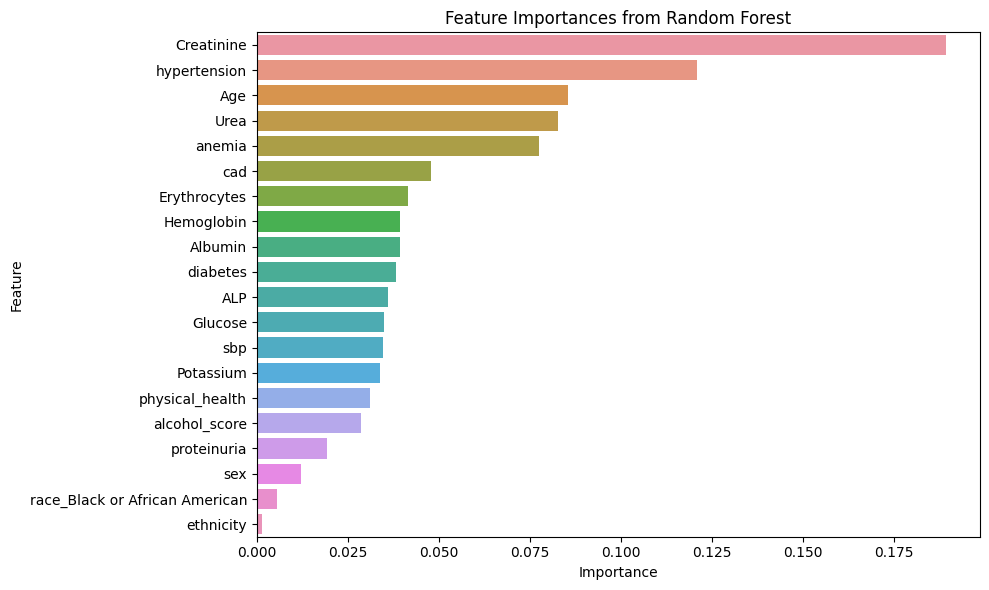

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
best_pipeline = grid.best_estimator_

#feature names
selector = best_pipeline.named_steps['select']
selected_indices = selector.get_support(indices=True)
selected_feature_names = [features_resampled_train.columns[i] for i in selected_indices]

#feature importance
rf_model = best_pipeline.named_steps['rf']
importances = rf_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importances from Random Forest")
plt.tight_layout()
plt.show()

Our tuned model is working better

## Try undersampling

In [36]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=2)
features_under_train, outcome_under_train = rus.fit_resample(features_train, outcome_train)

In [37]:
rForest_3 = RandomForestClassifier(n_estimators=100)
rForest_3.fit(features_under_train, outcome_under_train)

RandomForestClassifier()

In [38]:
y_pred_3 = rForest_3.predict(features_test)
print_classification_metrics(outcome_test,y_pred_3)

Accuracy: 0.8157502549219546
Precision: 0.512594131394443
Recall: 0.8070318887980377
F1 Score: 0.6269652215340639
Confusion Matrix:
 [[16852  3754]
 [  944  3948]]


In [39]:
grid_under_rf = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)
grid_under_rf.fit(features_under_train, outcome_under_train)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('rf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'rf__max_depth': [None, 20],
                         'rf__min_samples_split': [2, 5],
                         'rf__n_estimators': [100, 200],
                         'select__k': [10, 15, 20]},
             verbose=2)

In [40]:
best_model_under = grid_under_rf.best_estimator_

In [41]:
y_pred_under_rf = best_model_under.predict(features_test)
print_classification_metrics(outcome_test, y_pred_under_rf)

Accuracy: 0.8072397835124323
Precision: 0.49852620786876845
Recall: 0.7951757972199509
F1 Score: 0.612839700669555
Confusion Matrix:
 [[16693  3913]
 [ 1002  3890]]


In [42]:
print(grid_under_rf.best_params_)

{'rf__max_depth': 20, 'rf__min_samples_split': 2, 'rf__n_estimators': 200, 'select__k': 20}


While undersampling is an improvement, the model is still prone to false negatives, which is the biggest thing I want to avoid. I will try XGBoost next. 

# XGBoost

In [19]:
import xgboost


scale_pos_weight = (outcome_train == 0).sum() / (outcome_train == 1).sum()

model = xgboost.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    scale_pos_weight=scale_pos_weight,
    learning_rate=0.1,
    max_depth=6,
    n_estimators=100,
    random_state=42
)

In [20]:
model.fit(features_train, outcome_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [21]:
y_pred_xgboost = model.predict(features_test)
print_classification_metrics(outcome_test, y_pred_xgboost)

Accuracy: 0.8358302611969566
Precision: 0.5500851305334846
Recall: 0.7925183973834833
F1 Score: 0.6494137353433835
Confusion Matrix:
 [[17435  3171]
 [ 1015  3877]]


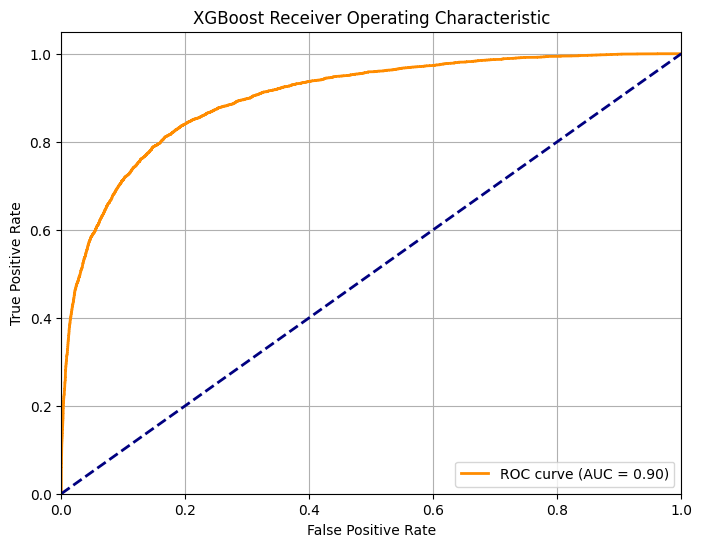

In [22]:
from sklearn.metrics import roc_auc_score, roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt

y_pred_prob = model.predict_proba(features_test)[:, 1]  # needed for ROC

fpr, tpr, thresholds = roc_curve(outcome_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # baseline
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.grid()
plt.show()

Hyperparameter tuning and feature reducing since this is my best model yet

Goal is to optimize recall so I miss as few CKD cases as possible. 
I am ok sacrificing precision to optimize recall. 
Included early stopping to stop the gridsearch if there is no imporvement after 10 rounds (to save time and compute power)

In [31]:
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import Pipeline

pipeline_xgb = Pipeline([
    ('select', SelectKBest(score_func=f_classif)),
    ('xgb', xgboost.XGBClassifier(random_state=42))
])


param_grid_xgb = {
    'select__k': [20, 25],
    'xgb__learning_rate': [0.05, 0.1],
    'xgb__max_depth': [6, 9], 
    'xgb__n_estimators': [300, 350],
    'xgb__scale_pos_weight': [5],
    'xgb__colsample_bytree': [0.8, 1.0],
    'xgb__max_delta_step': [1]

}


grid_search_xgb = GridSearchCV(
    estimator=pipeline_xgb,
    param_grid=param_grid_xgb,
    cv=3,  
    verbose=2,  
    n_jobs=-1, 
    scoring='recall', 
    refit=True
)

fit_params = {
    'xgb__eval_set': [(features_train, outcome_train), (features_test, outcome_test)],
    'xgb__early_stopping_rounds': 10  }


grid_search_xgb.fit(features_train, outcome_train)


Fitting 3 folds for each of 32 candidates, totalling 96 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('select', SelectKBest()),
                                       ('xgb',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      callbacks=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      device=None,
                                                      early_stopping_rounds=None,
                                                      enable_categorical=False,
                                                      eval_metric=None,
                                                      feature_types=None,
                                                      gamma=None,
                                                      grow_policy=None,
                                                      importance_type=None,...
                                                      monotone_constraints=None,
                                                      multi_strategy=None,
                                                      n_estimators=None,
                                                      n_jobs=None,
                                                      num_parallel_tree=None,
                                                      random_state=42, ...))]),
             n_jobs=-1,
             param_grid={'select__k': [20, 25],
                         'xgb__colsample_bytree': [0.8, 1.0],
                         'xgb__learning_rate': [0.05, 0.1],
                         'xgb__max_delta_step': [1], 'xgb__max_depth': [6, 9],
                         'xgb__n_estimators': [300, 350],
                         'xgb__scale_pos_weight': [5]},
             scoring='recall', verbose=2)

In [32]:
best_xgb_model = grid_search_xgb.best_estimator_

In [33]:
y_pred_gridsearch_xgb = grid_search_xgb.predict(features_test)
print_classification_metrics(outcome_test,y_pred_gridsearch_xgb)

Accuracy: 0.8247313514785474
Precision: 0.5279134221987594
Recall: 0.8176614881439084
F1 Score: 0.6415911460421846
Confusion Matrix:
 [[17029  3577]
 [  892  4000]]


In [34]:
print(grid_search_xgb.best_params_)

{'select__k': 25, 'xgb__colsample_bytree': 0.8, 'xgb__learning_rate': 0.05, 'xgb__max_delta_step': 1, 'xgb__max_depth': 6, 'xgb__n_estimators': 300, 'xgb__scale_pos_weight': 5}
[CV] END select__k=20, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_delta_step=1, xgb__max_depth=6, xgb__n_estimators=300, xgb__scale_pos_weight=5; total time=   4.7s
[CV] END select__k=20, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_delta_step=1, xgb__max_depth=9, xgb__n_estimators=300, xgb__scale_pos_weight=5; total time=   8.6s
[CV] END select__k=20, xgb__colsample_bytree=0.8, xgb__learning_rate=0.05, xgb__max_delta_step=1, xgb__max_depth=9, xgb__n_estimators=350, xgb__scale_pos_weight=5; total time=   9.6s
[CV] END select__k=20, xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_delta_step=1, xgb__max_depth=6, xgb__n_estimators=350, xgb__scale_pos_weight=5; total time=   4.9s
[CV] END select__k=20, xgb__colsample_bytree=0.8, xgb__learning_rate=0.1, xgb__max_delta_ste

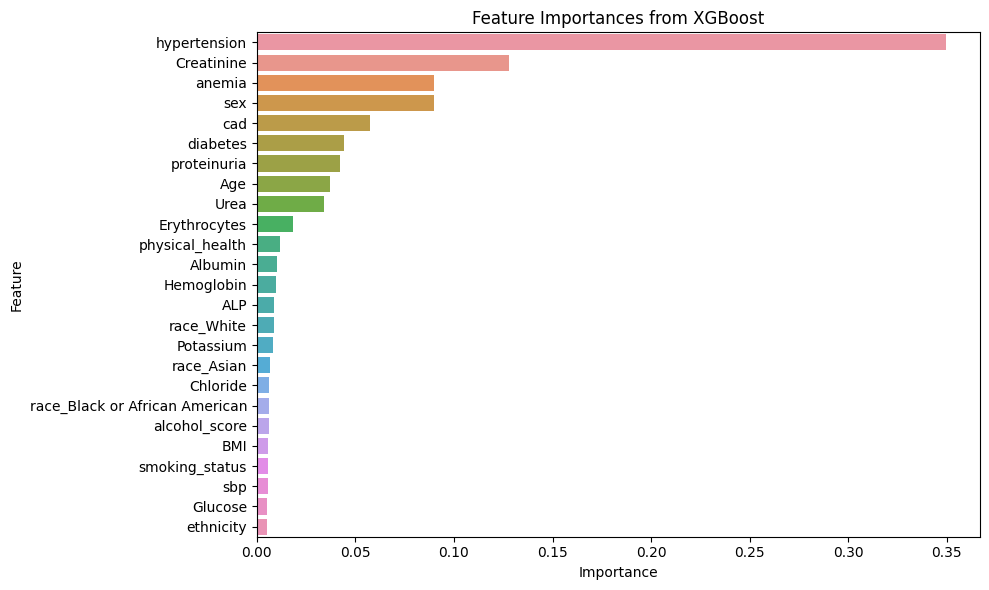

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns
best_pipeline = grid_search_xgb.best_estimator_

#feature names
selector = best_pipeline.named_steps['select']
selected_indices = selector.get_support(indices=True)
selected_feature_names = [features_resampled_train.columns[i] for i in selected_indices]

#feature importance
xgb_model = best_pipeline.named_steps['xgb']
importances = xgb_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'Feature': selected_feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title("Feature Importances from XGBoost")
plt.tight_layout()
plt.show()

Confusion Matrix:
 [[17029  3577]
 [  892  4000]]


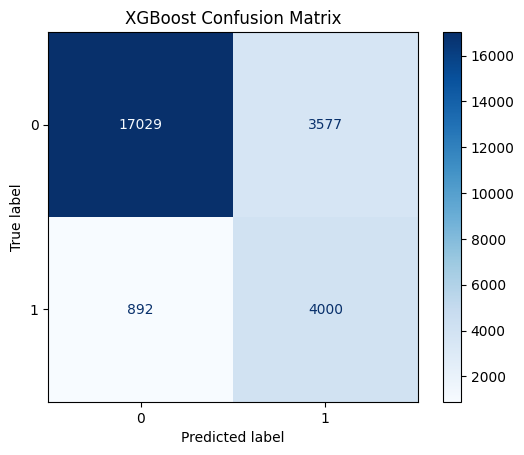

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(outcome_test, y_pred_gridsearch_xgb)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', values_format='d')
plt.title("XGBoost Confusion Matrix")
plt.show()

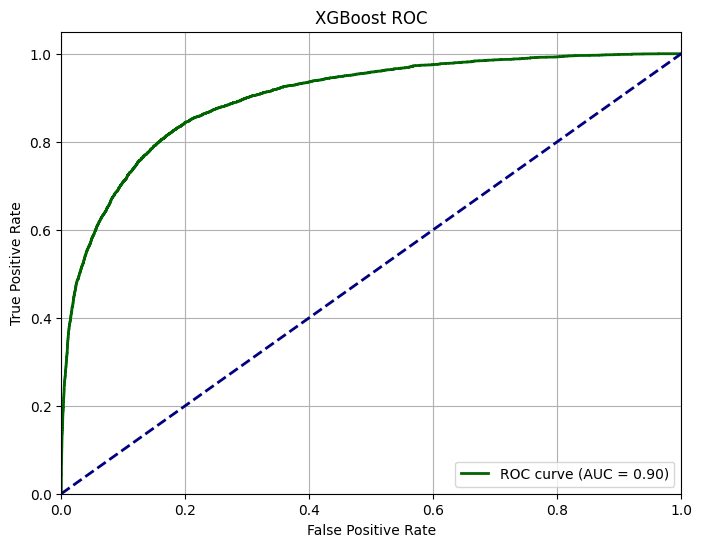

In [37]:
y_pred_prob_xgb = best_xgb_model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(outcome_test, y_pred_prob_xgb)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, color='darkgreen', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGBoost ROC')
plt.legend(loc="lower right")
plt.grid()

# AdaBoost

In [68]:
from sklearn.ensemble import AdaBoostClassifier

base_model = DecisionTreeClassifier(max_depth=3)


In [69]:

# Create the AdaBoost model
adaboost_model = AdaBoostClassifier(
    estimator=base_model,
    n_estimators=50,
    learning_rate=1.0,
    random_state=42
)

In [70]:
adaboost_model.fit(features_resampled_train, outcome_resampled_train)

/home/jupyter/.local/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=300, xgb__scale_pos_weight=2; total time=   5.3s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=300, xgb__scale_pos_weight=2; total time=   5.3s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=2; total time=   6.8s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=400, xgb__scale_pos_weight=5; total time=   6.8s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=6, xgb__n_estimators=500, xgb__scale_pos_weight=2; total time=   8.2s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=300, xgb__scale_pos_weight=2; total time=  10.0s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=9, xgb__n_estimators=300, xgb__scale_pos_weight=5; total time=  10.3s
[CV] END select__k=25, xgb__learning_rate=0.05, xgb__max_depth=9, xgb

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=3),
                   random_state=42)

In [72]:
y_pred_adaboost = adaboost_model.predict(features_test)
print_classification_metrics(outcome_test, y_pred_adaboost)

Accuracy: 0.871558553612048
Precision: 0.7166979362101313
Recall: 0.5466067048242028
F1 Score: 0.6202017859213731
Confusion Matrix:
 [[19549  1057]
 [ 2218  2674]]


# Deep Learning Approach

Using the class_weights feature to inform the model of my imbalanced dataset. 

In [73]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from sklearn.utils import class_weight
import numpy as np
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(outcome_train),
    y=outcome_train
)

# Turn into dictionary format for Keras
class_weights = dict(enumerate(class_weights))
print(class_weights) 

2025-04-24 04:43:08.305715: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-24 04:43:27.626811: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-24 04:43:27.628502: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such 

{0: 0.616508493018195, 1: 2.645766317318668}


In [53]:
neural_network = Sequential([
    Dense(64, activation='relu', input_shape=(features_under_train.shape[1],)),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])
neural_network.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

2025-04-20 16:03:36.629732: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-04-20 16:03:36.641794: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-20 16:03:36.641870: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (all-of-us-27302-m): /proc/driver/nvidia/version does not exist
2025-04-20 16:03:36.676708: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-criti

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

features_train = features_train.astype('float32').values


early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

neural_network.fit(
    features_train,
    outcome_train,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop]
)

Epoch 1/50
2550/2550 [==============================] - 8s 2ms/step - loss: 0.4776 - accuracy: 0.7806 - val_loss: 0.4509 - val_accuracy: 0.8008
Epoch 2/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4476 - accuracy: 0.8013 - val_loss: 0.4395 - val_accuracy: 0.8082
Epoch 3/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4402 - accuracy: 0.8070 - val_loss: 0.4496 - val_accuracy: 0.8004
Epoch 4/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4366 - accuracy: 0.8040 - val_loss: 0.4162 - val_accuracy: 0.8072
Epoch 5/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4331 - accuracy: 0.8048 - val_loss: 0.4324 - val_accuracy: 0.8076
Epoch 6/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4327 - accuracy: 0.8090 - val_loss: 0.4311 - val_accuracy: 0.7952
Epoch 7/50
2550/2550 [==============================] - 5s 2ms/step - loss: 0.4302 - accuracy: 0.8045 - val_loss: 0.4169 - val_accuracy:

In [55]:
features_test = features_test.astype('float32').values

y_predict_nn = neural_network.predict(features_test)

797/797 [==============================] - 1s 1ms/step


In [56]:
y_predict_nn = (neural_network.predict(features_test) > 0.5).astype("int32")

797/797 [==============================] - 1s 1ms/step


In [57]:
print_classification_metrics(outcome_test,y_predict_nn)

Accuracy: 0.8269668209271316
Precision: 0.5315665325378105
Recall: 0.7871378672693651
F1 Score: 0.6345867152559218
Confusion Matrix:
 [[17255  3376]
 [ 1036  3831]]
